## 1. Introduction to sentiment analysis in finance with VADER

- **VADER** is a **rule-based sentiment analysis algorithm**, that uses a set of rules to specify a mathematical model without explicitly coding it. It consumes fewer resources as compared to Machine Learning models as there is no need for vast amounts of training data. Its resource-efficient approach helps us to decode and quantify **the emotions** contained in streaming media such as **text, audio or video**. 

- **VADER** stands for **V**alence **A**ware **D**ictionary for s**E**ntiment **R**easoning.

### 1.1 How accurate is VADER?

- Study shows that VADER performs as good as individual human raters at matching ground truth. In fact, by inspecting the F1 scores, we see that VADER (0.96) outperforms individual human raters (0.84) at correctly labelling the sentiment of tweets into positive, neutral, or negative classes. The reason behind this is that VADER is sensitive to both **Polarity** (whether the sentiment is positive or negative) and **Intensity** (how positive or negative is sentiment) of emotions.

- VADER incorporates this by providing **a Valence Score** to the word into consideration. This brings us to the next section.

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests 
import yfinance as yf
from wordcloud import WordCloud, STOPWORDS
from pandas.tseries.offsets import BDay
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Create an analyzer object
analyzer = SentimentIntensityAnalyzer()

In [ ]:
sentences = ["Bob is smart, and awesome.",  
             "Bob is a shitty guy xd!",  
             "Bob is super cute !!",   
             "Bob is normal.", 
             "Bob isn't smart at all."
             ]


for i in range(len(sentences)):
    vs = analyzer.polarity_scores(sentences[i])
    print("{} --> {}".format(sentences[i], str(vs)))

Bob is smart, and awesome. --> {'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'compound': 0.7783}
Bob is a shitty guy xd! --> {'neg': 0.337, 'neu': 0.281, 'pos': 0.383, 'compound': 0.126}
Bob is super cute !! --> {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.8168}
Bob is normal. --> {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bob isn't smart at all. --> {'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'compound': -0.3089}


In [ ]:
# Get AAPL data stock for year 2021
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-1-1", end="2021-12-31", interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,132.533066,132.622397,125.823032,128.453445,143301900,0.0,0
2021-01-05,127.937271,130.766210,127.480664,130.041595,97664900,0.0,0
2021-01-06,126.775931,130.081319,125.445832,125.664207,155088000,0.0,0
2021-01-07,127.411196,130.657029,126.914892,129.952271,109578200,0.0,0
2021-01-08,131.451110,131.649643,129.267374,131.073929,105158200,0.0,0


## 2. Scraping news articles about AAPL stock

In [ ]:
# Define the endpoint
url = 'https://newsapi.org/v2/everything?'

# Specify the query and number of returns
parameters = {'q': 'Apple', # query phrase
              'sortBy': 'popularity', # articles from popular sources and publishers come first
              'pageSize': 100,  # maximum is 100 for developer version
              'apiKey': '77869638ed9348c3a5fdb9ea5ca4670b', # your own API key
          }

# Make a GET request to news API
response = requests.get(url, params=parameters)

In [ ]:
# Make a news dataframe
df_news = pd.DataFrame(response.json()['articles'])
df_news['publishedAt'] = pd.to_datetime(df_news['publishedAt'])
df_news.sort_values(by='publishedAt', inplace=True)
df_news.head(6)

,source,author,title,description,url,urlToImage,publishedAt,content
54,"{'id': 'the-verge', 'name': 'The Verge'}",Emma Roth,Apple TV Plus teases its WeWork series with Ja...,Apple TV Plus’ upcoming WeWork miniseries star...,https://www.theverge.com/2022/1/19/22891975/ap...,https://cdn.vox-cdn.com/thumbor/w9rAdXoPLrKR7t...,2022-01-19 23:00:46+00:00,Photo by Apple\r\n\n \n\n A new trailer gives ...
53,"{'id': 'the-verge', 'name': 'The Verge'}",Mitchell Clark,Here’s how to clean your $19 Apple cleaning cloth,If you were able to get your hands on one of A...,https://www.theverge.com/tldr/2022/1/19/228922...,https://cdn.vox-cdn.com/thumbor/t4xZYaJpeE-GaM...,2022-01-20 01:43:28+00:00,"Filed under:\r\nShockingly, the process doesnt..."
8,"{'id': 'engadget', 'name': 'Engadget'}",Mat Smith,The Morning After: Apple closes education disc...,Apple has finally closed a loophole in the US ...,https://www.engadget.com/the-morning-after-app...,https://s.yimg.com/os/creatr-uploaded-images/2...,2022-01-20 12:27:53+00:00,Apple has finally closed a loophole in the US ...
49,"{'id': 'wired', 'name': 'Wired'}",Caitlin Harrington,Why Big Tech Companies Have Been Quiet on Texa...,"As the anniversary of Roe v. Wade nears, press...",https://www.wired.com/story/why-big-tech-quiet...,https://media.wired.com/photos/61e866ff03f9ae9...,2022-01-20 13:00:00+00:00,Most companies that signed the letters were mi...
59,"{'id': 'the-verge', 'name': 'The Verge'}",Jon Porter,Streaming music report sheds light on battle b...,Spotify was the largest music streaming servic...,https://www.theverge.com/2022/1/20/22892939/mu...,https://cdn.vox-cdn.com/thumbor/DLF63pHQldqqEP...,2022-01-20 13:28:25+00:00,Spotifys still way ahead\r\nMarket share for t...
5,"{'id': None, 'name': 'Lifehacker.com'}",Beth Skwarecki,Why You Should Stop ‘Gamifying’ Your Health an...,"Whenever there’s a task you don’t want to do, ...",https://lifehacker.com/why-you-should-stop-gam...,https://i.kinja-img.com/gawker-media/image/upl...,2022-01-20 14:00:00+00:00,"Whenever theres a task you dont want to do, th..."


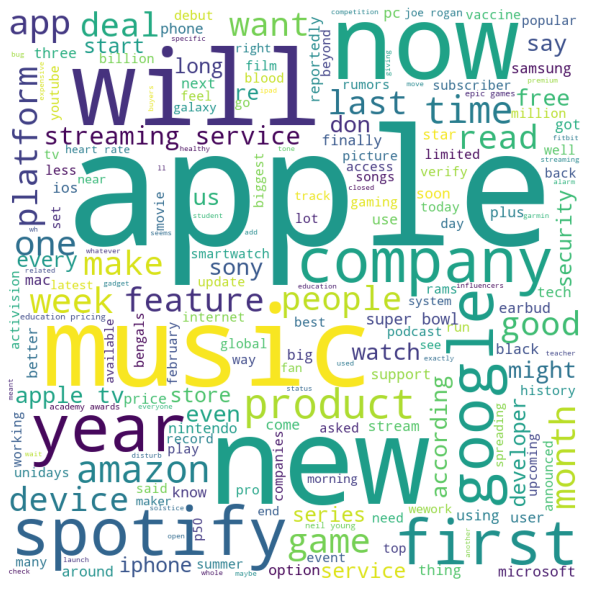

In [ ]:
# Visualizing most common words abt Apple
stopwords = set(STOPWORDS)
words = ""
for descrip in df_news['description']: 
    tokens = descrip.split()
    tokens = [token.lower() for token in tokens]
    words += " ".join(tokens)

wordcloud = WordCloud(width = 800,
                      height = 800, 
                      background_color ='white', 
                      stopwords = stopwords, 
                      min_font_size = 10).generate(words) 
  
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

- The problem that might occur is that the news date can be a week-end day , or some holiday day. So, we need to convert those days into either previous or next business days

In [ ]:
# Get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
df_news["trading_time"] = df_news["publishedAt"].apply(get_trade_open)
df_news = df_news[pd.notnull(df_news['trading_time'])]
df_news['Date'] = pd.to_datetime(pd.to_datetime(df_news['trading_time']).dt.date)
df_news.head(6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,source,author,title,description,url,urlToImage,publishedAt,content,trading_time,Date
54,"{'id': 'the-verge', 'name': 'The Verge'}",Emma Roth,Apple TV Plus teases its WeWork series with Ja...,Apple TV Plus’ upcoming WeWork miniseries star...,https://www.theverge.com/2022/1/19/22891975/ap...,https://cdn.vox-cdn.com/thumbor/w9rAdXoPLrKR7t...,2022-01-19 23:00:46+00:00,Photo by Apple\r\n\n \n\n A new trailer gives ...,2022-01-20 13:30:00+00:00,2022-01-20
53,"{'id': 'the-verge', 'name': 'The Verge'}",Mitchell Clark,Here’s how to clean your $19 Apple cleaning cloth,If you were able to get your hands on one of A...,https://www.theverge.com/tldr/2022/1/19/228922...,https://cdn.vox-cdn.com/thumbor/t4xZYaJpeE-GaM...,2022-01-20 01:43:28+00:00,"Filed under:\r\nShockingly, the process doesnt...",2022-01-20 13:30:00+00:00,2022-01-20
8,"{'id': 'engadget', 'name': 'Engadget'}",Mat Smith,The Morning After: Apple closes education disc...,Apple has finally closed a loophole in the US ...,https://www.engadget.com/the-morning-after-app...,https://s.yimg.com/os/creatr-uploaded-images/2...,2022-01-20 12:27:53+00:00,Apple has finally closed a loophole in the US ...,2022-01-20 13:30:00+00:00,2022-01-20
49,"{'id': 'wired', 'name': 'Wired'}",Caitlin Harrington,Why Big Tech Companies Have Been Quiet on Texa...,"As the anniversary of Roe v. Wade nears, press...",https://www.wired.com/story/why-big-tech-quiet...,https://media.wired.com/photos/61e866ff03f9ae9...,2022-01-20 13:00:00+00:00,Most companies that signed the letters were mi...,2022-01-20 13:30:00+00:00,2022-01-20
59,"{'id': 'the-verge', 'name': 'The Verge'}",Jon Porter,Streaming music report sheds light on battle b...,Spotify was the largest music streaming servic...,https://www.theverge.com/2022/1/20/22892939/mu...,https://cdn.vox-cdn.com/thumbor/DLF63pHQldqqEP...,2022-01-20 13:28:25+00:00,Spotifys still way ahead\r\nMarket share for t...,2022-01-20 13:30:00+00:00,2022-01-20
78,"{'id': None, 'name': 'Gizmodo.com'}",Florence Ion,"Ready for Google Glass, Round Two?",With every tech giant from Apple to Microsoft ...,https://gizmodo.com/ready-for-google-glass-rou...,https://i.kinja-img.com/gawker-media/image/upl...,2022-01-20 22:20:00+00:00,With every tech giant from Apple to Microsoft ...,2022-01-21 13:30:00+00:00,2022-01-21


In [ ]:
# Add a column for compound VADER score
df_news['compound_vader_score'] = df_news['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_news = df_news[(df_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)
df_news.head()

,source,author,title,description,url,urlToImage,publishedAt,content,trading_time,Date,compound_vader_score
0,"{'id': 'the-verge', 'name': 'The Verge'}",Emma Roth,Apple TV Plus teases its WeWork series with Ja...,Apple TV Plus’ upcoming WeWork miniseries star...,https://www.theverge.com/2022/1/19/22891975/ap...,https://cdn.vox-cdn.com/thumbor/w9rAdXoPLrKR7t...,2022-01-19 23:00:46+00:00,Photo by Apple\r\n\n \n\n A new trailer gives ...,2022-01-20 13:30:00+00:00,2022-01-20,-0.2960
1,"{'id': 'the-verge', 'name': 'The Verge'}",Mitchell Clark,Here’s how to clean your $19 Apple cleaning cloth,If you were able to get your hands on one of A...,https://www.theverge.com/tldr/2022/1/19/228922...,https://cdn.vox-cdn.com/thumbor/t4xZYaJpeE-GaM...,2022-01-20 01:43:28+00:00,"Filed under:\r\nShockingly, the process doesnt...",2022-01-20 13:30:00+00:00,2022-01-20,0.4019
2,"{'id': 'the-verge', 'name': 'The Verge'}",Jon Porter,Streaming music report sheds light on battle b...,Spotify was the largest music streaming servic...,https://www.theverge.com/2022/1/20/22892939/mu...,https://cdn.vox-cdn.com/thumbor/DLF63pHQldqqEP...,2022-01-20 13:28:25+00:00,Spotifys still way ahead\r\nMarket share for t...,2022-01-20 13:30:00+00:00,2022-01-20,-0.2263
3,"{'id': None, 'name': 'Gizmodo.com'}",Florence Ion,"Ready for Google Glass, Round Two?",With every tech giant from Apple to Microsoft ...,https://gizmodo.com/ready-for-google-glass-rou...,https://i.kinja-img.com/gawker-media/image/upl...,2022-01-20 22:20:00+00:00,With every tech giant from Apple to Microsoft ...,2022-01-21 13:30:00+00:00,2022-01-21,0.3612
4,"{'id': 'the-verge', 'name': 'The Verge'}",Jon Porter,We regret to inform you that Apple now verifie...,Apple will now verify that customers in the US...,https://www.theverge.com/2022/1/21/22894665/ap...,https://cdn.vox-cdn.com/thumbor/0Y5cqw5whXX_fr...,2022-01-21 12:39:17+00:00,Youll now need to be verified via Unidays in t...,2022-01-21 13:30:00+00:00,2022-01-21,-0.4215


In [ ]:
df_news.groupby(['Date']).agg(list)

,source,author,title,description,url,urlToImage,publishedAt,content,trading_time,compound_vader_score
Date,,,,,,,,,,
2022-01-20,"[{'id': 'the-verge', 'name': 'The Verge'}, {'i...","[Emma Roth, Mitchell Clark, Jon Porter]",[Apple TV Plus teases its WeWork series with J...,[Apple TV Plus’ upcoming WeWork miniseries sta...,[https://www.theverge.com/2022/1/19/22891975/a...,[https://cdn.vox-cdn.com/thumbor/w9rAdXoPLrKR7...,"[2022-01-19 23:00:46+00:00, 2022-01-20 01:43:2...",[Photo by Apple\r\n\n \n\n A new trailer gives...,"[2022-01-20 13:30:00+00:00, 2022-01-20 13:30:0...","[-0.296, 0.4019, -0.2263]"
2022-01-21,"[{'id': None, 'name': 'Gizmodo.com'}, {'id': '...","[Florence Ion, Jon Porter, Nina Jankowicz]","[Ready for Google Glass, Round Two?, We regret...",[With every tech giant from Apple to Microsoft...,[https://gizmodo.com/ready-for-google-glass-ro...,[https://i.kinja-img.com/gawker-media/image/up...,"[2022-01-20 22:20:00+00:00, 2022-01-21 12:39:1...",[With every tech giant from Apple to Microsoft...,"[2022-01-21 13:30:00+00:00, 2022-01-21 13:30:0...","[0.3612, -0.4215, -0.5106]"
2022-01-24,"[{'id': 'engadget', 'name': 'Engadget'}]",[Mat Smith],[The Morning After: The Steam Deck will suppor...,[Cheating is rife across many gaming platforms...,[https://www.engadget.com/the-morning-after-th...,[https://s.yimg.com/os/creatr-images/2019-10/e...,[2022-01-24 12:15:18+00:00],[Cheating is rife across many gaming platforms...,[2022-01-24 13:30:00+00:00],[0.4019]
2022-01-25,"[{'id': 'engadget', 'name': 'Engadget'}, {'id'...","[Jon Fingas, Morgan Meaker]",[Apple's MacBook Air M1 drops to $850 at Amazo...,[Don't worry about paying full price for the M...,[https://www.engadget.com/apple-macbook-air-m1...,[https://s.yimg.com/os/creatr-uploaded-images/...,"[2022-01-24 21:21:22+00:00, 2022-01-25 12:00:0...",[Don't worry about paying full price for the M...,"[2022-01-25 13:30:00+00:00, 2022-01-25 13:30:0...","[0.1779, 0.4201]"
2022-01-26,"[{'id': None, 'name': 'Lifehacker.com'}, {'id'...","[Jake Peterson, Mat Smith]",[Your iPhone's Alarm Doesn't Have to Be so Ann...,[We all know the iPhone’s alarm is anything bu...,[https://lifehacker.com/your-iphones-alarm-doe...,[https://i.kinja-img.com/gawker-media/image/up...,"[2022-01-25 21:00:00+00:00, 2022-01-26 12:15:4...",[We all know the iPhones alarm is anything but...,"[2022-01-26 13:30:00+00:00, 2022-01-26 13:30:0...","[-0.7088, -0.3818]"
2022-01-27,"[{'id': None, 'name': 'Gizmodo.com'}]",[Shoshana Wodinsky],[LG’s Latest Announcement Solidifies Everythin...,[It’s a well established fact on the internet ...,[https://gizmodo.com/lg-s-latest-announcement-...,[https://i.kinja-img.com/gawker-media/image/up...,[2022-01-26 21:30:00+00:00],[Its a well established fact on the internet t...,[2022-01-27 13:30:00+00:00],[-0.4767]
2022-01-28,"[{'id': 'the-verge', 'name': 'The Verge'}, {'i...","[Tom Warren, Daniel Cooper, Phillip Tracy]","[Apple now has 1.8 billion active devices, The...",[Apple now has 1.8 billion active devices worl...,[https://www.theverge.com/2022/1/28/22906071/a...,[https://cdn.vox-cdn.com/thumbor/EH6wOPkCtsfHY...,"[2022-01-28 11:24:40+00:00, 2022-01-28 12:15:2...",[Apples device numbers jump as it posts record...,"[2022-01-28 13:30:00+00:00, 2022-01-28 13:30:0...","[0.4019, 0.3612, 0.3612]"
2022-01-31,"[{'id': 'engadget', 'name': 'Engadget'}, {'id'...","[Jon Fingas, The New York Times, Justin Carter...","[Epic gains support from Microsoft, 35 states ...",[Epic Games has some important allies in its b...,[https://www.engadget.com/epic-35-states-suppo...,[https://s.yimg.com/os/creatr-uploaded-images/...,"[2022-01-29 15:30:07+00:00, 2022-01-29 16:00:1...",[Epic Games has some important allies in its b...,"[2022-01-31 13:30:00+00:00, 2022-01-31 13:30:0...","[0.3612, -0.2732, 0.6249, -0.4767, 0.5994]"
2022-02-02,"[{'id': None, 'name': 'New York Times'}]",[Noel Murray],"[The Best Movies and TV Shows Coming to HBO, H...","[Every month, streaming services add movies an...",[https://www.nytimes.co